In [9]:
from math import log, sqrt

import matplotlib.pyplot as plt
import numpy as np

## Taken from https://codereview.stackexchange.com/questions/108263/alternating-direction-method-of-multipliers#:~:text=import%20numpy%20as%20np%20import%20matplotlib.pyplot%20as%20plt,optimisation%20that%20is%20used%20widely%20in%20statistics%20%28http%3A%2F%2Fstanford.edu%2F~boyd%2Fadmm.html%29.


def ADMM(A, y):
    """Alternating Direction Method of Multipliers

    This is a python implementation of the Alternating Direction
    Method of Multipliers - a method of constrained optimisation
    that is used widely in statistics (http://stanford.edu/~boyd/admm.html).

    This is simplified version, specifically for the LASSO
    """

    m, n = A.shape
    A_t_A = A.T.dot(A)
    w, v = np.linalg.eig(A_t_A)
    MAX_ITER = 10000

    # Function to caluculate min 1/2(y - Ax) + l||x||
    # via alternating direction methods
    x_hat = np.zeros([n, 1])
    z_hat = np.zeros([n, 1])
    u = np.zeros([n, 1])

    # Calculate regression co-efficient and stepsize
    r = np.amax(np.absolute(w))
    l_over_rho = sqrt(2 * log(n, 10)) * r / 2.0  # I might be wrong here
    rho = 1 / r

    # Pre-compute to save some multiplications
    A_t_y = A.T.dot(y)
    Q = A_t_A + rho * np.identity(n)
    Q = np.linalg.inv(Q)
    Q_dot = Q.dot
    sign = np.sign
    maximum = np.maximum
    absolute = np.absolute

    for _ in range(MAX_ITER):
        # x minimisation step via posterier OLS
        x_hat = Q_dot(A_t_y + rho * (z_hat - u))
        # z minimisation via soft-thresholding
        u = x_hat + u
        z_hat = sign(u) * maximum(0, absolute(u) - l_over_rho)
        # mulitplier update
        u = u - z_hat

    return z_hat


def test(m=50, n=200):
    """Test the ADMM method with randomly generated matrices and vectors"""
    A = np.random.randn(m, n)

    num_non_zeros = 10
    positions = np.random.randint(0, n, num_non_zeros)
    amplitudes = 100 * np.random.randn(num_non_zeros, 1)
    x = np.zeros((n, 1))
    x[positions] = amplitudes

    y = A.dot(x) + np.random.randn(m, 1)

    plot(x, ADMM(A, y))


def plot(original, computed):
    """Plot two vectors to compare their values"""
    plt.plot(original, label="Original",lw=5)
    plt.plot(computed, label="Estimate",lw=2)

    plt.legend(loc="upper right")


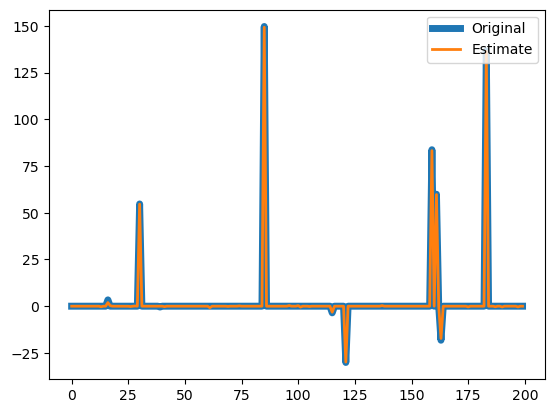

In [10]:
test()